In [1]:
import os
import cv2
import csv
import math
import shutil
import random
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Data Storage

Original data is in subdirectories, with each video under one condition (thus so are all frames per video)

Steps: 
1. Read in CSV file with labels for each video
2. Iterate through each subdirectory, copying each image to new directory and label each image with its parent video's y label

In [5]:
os.chdir("/Users/scampione/MSDS/Spring_24_2/Deep Learning")

In [6]:
csv_path = "./data/labels_total.csv"

In [7]:
df = pd.read_csv(csv_path)
df['cond'] = [1 if x == 'P' else 0 for x in df['label']]
df.head()

,video,dog id,label,cond
0,6,4,N,0
1,13,17,N,0
2,22,6,P,1
3,25,7,P,1
4,32,16,N,0


In [8]:
df['label'].value_counts()

label
N    153
P     81
Name: count, dtype: int64

In [9]:
df['dog id'].nunique()

29

In [23]:
# read csv and create dictionary to map video_id to y label
with open(csv_path) as f:
    header = f.readline()
    lines = f.readlines()

condition_per_video = {line.strip().split(',')[0]: 1 if line.strip().split(',')[2] == 'P' else 0 for line in lines}

In [11]:
PATH = "./data/dog_data_input"
os.listdir(PATH)[:5] # Subdirectories = video_id

['17289302', '10387530', '56565671', '50594650', '362']

In [98]:
video_ids = [f for f in os.listdir('.') if f != '.DS_Store' ]

# Splitting data indices into train, val, and test
train_val_dirs, test_dirs = train_test_split(video_ids, test_size=0.2, random_state=10)  # 20% data as test
train_dirs, val_dirs = train_test_split(train_val_dirs, test_size=0.25, random_state=10)  # 25% of remaining data as validation

print(len(train_dirs), len(val_dirs), len(test_dirs))

145 49 49


In [ ]:
# Train Directory
new_dir = './data/dogs/dog_train'
os.makedirs(new_dir, exist_ok=True)
train_labels = []

for subdir in train_dirs:
    if subdir != '.DS_Store':  # Exclude the .DS_Store file on macOS
        sub_path = os.path.join(subdir, "masked/1")
        if os.path.exists(sub_path):
            for img in os.listdir(sub_path):
                if subdir in condition_per_video.keys():
                    # Save label
                    train_labels.append([img, condition_per_video[subdir]])

                    # Copy image
                    source_path = os.path.join(sub_path, img)
                    destination_path = os.path.join(new_dir, img)
                    shutil.copy(source_path, destination_path)


# Save labels to new file
labels_file = '.data/dogs/dog_train_labels.csv'
with open(labels_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(train_labels)


In [ ]:
# Validation set
new_dir = './dogs/dog_val'
os.makedirs(new_dir, exist_ok=True)
val_labels = []

for subdir in val_dirs:
    if subdir != '.DS_Store':  # Exclude the .DS_Store file on macOS
        sub_path = os.path.join(subdir, "masked/1")
        if os.path.exists(sub_path):
            for img in os.listdir(sub_path):
                if subdir in condition_per_video.keys():
                    # Save label
                    val_labels.append([img, condition_per_video[subdir]])

                    # Copy image
                    source_path = os.path.join(sub_path, img)
                    destination_path = os.path.join(new_dir, img)
                    shutil.copy(source_path, destination_path)


# Save labels to new file
labels_file = '.data/dogs/dog_val_labels.csv'
with open(labels_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(val_labels)


In [ ]:
# Test set
new_dir = '.data/dogs/dog_test'
os.makedirs(new_dir, exist_ok=True)
test_labels = []

for subdir in test_dirs:
    if subdir != '.DS_Store':  # Exclude the .DS_Store file on macOS
        sub_path = os.path.join(subdir, "masked/1")
        if os.path.exists(sub_path):
            for img in os.listdir(sub_path):
                if subdir in condition_per_video.keys():
                    # Save label
                    test_labels.append([img, condition_per_video[subdir]])

                    # Copy image
                    source_path = os.path.join(sub_path, img)
                    destination_path = os.path.join(new_dir, img)
                    shutil.copy(source_path, destination_path)


# Save labels to new file
labels_file = '.data/dogs/dog_test_labels.csv'
with open(labels_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(test_labels)

## Data Resizing

Original images are different sizes. We will 

In [53]:
PATH = Path("./data/dogs")
list(PATH.iterdir())

[PosixPath('data/dogs2/.DS_Store'),
 PosixPath('data/dogs2/dog_val'),
 PosixPath('data/dogs2/dog_train_labels.csv'),
 PosixPath('data/dogs2/dog_train'),
 PosixPath('data/dogs2/dog_val_labels.csv'),
 PosixPath('data/dogs2/dog_test_labels.csv'),
 PosixPath('data/dogs2/dog_test')]

In [51]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

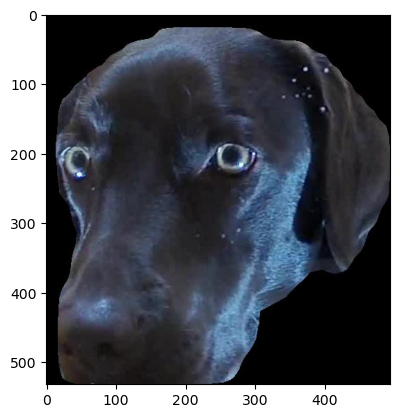

In [54]:
path = PATH/'dog_train/10387530-0001.jpg'
im = read_image(path)
plt.imshow(im)

In [55]:
im = cv2.imread(str(path))  #.astype(np.float32)/255
im.shape

(532, 495, 3)

In [56]:
path = PATH/'dog_train'
files = list(path.iterdir())[:200]
dims = [read_image(str(p)).shape for p in files]
dims[:10]

[(497, 422, 3),
 (281, 208, 3),
 (429, 505, 3),
 (512, 518, 3),
 (535, 604, 3),
 (534, 521, 3),
 (442, 457, 3),
 (448, 668, 3),
 (208, 222, 3),
 (580, 574, 3)]

In [59]:
# make new directory for resized training images
(PATH/"dog_train_resized").mkdir(parents=True, exist_ok=True)
(PATH/"dog_val_resized").mkdir(parents=True, exist_ok=True)
(PATH/"dog_test_resized").mkdir(parents=True, exist_ok=True)

In [61]:
def crop(im, start_r, start_c, height, width):
    return im[start_r:start_r + height, start_c:start_c + width]

def center_crop_square(im, scale_factor=1.0):
    """
    Returns a smaller center crop of an image based on a scaling factor.

    Args:
        im: Input image in NumPy array format.
        scale_factor: Float value representing the percentage of the original size
                      for the cropped area. A value between 0 and 1, e.g., 0.8 for 80%.
    """
    r, c, *_ = im.shape
    min_sz = min(r, c)

    # Determine the new size of the smaller crop
    crop_sz = int(min_sz * scale_factor)

    # Calculate the starting points for cropping
    start_r = math.ceil((r - crop_sz) / 2)
    start_c = math.ceil((c - crop_sz) / 2)

    return crop(im, start_r, start_c, crop_sz, crop_sz)

def get_a_crop(path, sz=250, scale_factor=1.0):
    im = cv2.imread(str(path))
    return cv2.resize(center_crop_square(im, scale_factor), (sz, sz))


In [62]:
def pad_and_resize(im, target_size=250, padding_factor=1.5):
    """
    Pads an image to a larger square before cropping to the desired size.

    Args:
        im: Input image in NumPy array format.
        target_size: The final size to which the image will be resized.
        padding_factor: Multiplier to control the amount of padding. For example, 1.5 will make the padded square 1.5x larger than the largest dimension of the original image.

    Returns:
        A padded and resized square image of `target_size`.
    """
    r, c, *_ = im.shape
    max_dim = max(r, c)

    # Calculate the size of the larger padded square
    padded_size = int(max_dim * padding_factor)

    # Calculate padding amounts to center the original image in the larger square
    pad_top = (padded_size - r) // 2
    pad_bottom = padded_size - r - pad_top
    pad_left = (padded_size - c) // 2
    pad_right = padded_size - c - pad_left

    # Create the padded square image
    padded_im = cv2.copyMakeBorder(
        im, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=[0, 0, 0]
    )

    # Resize the padded square to the target size
    resized_im = cv2.resize(padded_im, (target_size, target_size))

    return resized_im

def get_a_crop(path, target_size=250, padding_factor=1.5):
    """
    Pads an image to a larger square before resizing to the final target size.

    Args:
        path: Path to the image.
        target_size: The final size to which the image will be resized.
        padding_factor: Multiplier to control the amount of padding.

    Returns:
        A padded and resized square image.
    """
    im = cv2.imread(str(path))
    return pad_and_resize(im, target_size, padding_factor)


def crop(im, start_r, start_c, height, width):
    return im[start_r:start_r + height, start_c:start_c + width]


In [63]:
def resize_all_images(new_path, old_path):
    orig_path = Path(str(new_path).split("_")[0])
    files = list(old_path.iterdir())
    for f in files:
        img = get_a_crop(f)
        path = new_path/f.name
        cv2.imwrite(str(path), img)

In [64]:
resize_all_images(new_path=PATH/"dog_train_resized/", old_path = PATH/'dog_train')

In [ ]:
def get_image_files(directory, extensions=('.jpg', '.jpeg', '.png')):
    """
    Returns a list of image files from the directory, filtering by the given extensions.
    """
    return [f for f in Path(directory).iterdir() if f.suffix.lower() in extensions]

In [65]:
image_directory = PATH/'dog_train_resized'
image_files = get_image_files(image_directory)

# Example of processing only image files
for img_file in image_files:
    image = cv2.imread(str(img_file))
    if image is None:
        print(f"Could not read image: {img_file}")
    else:
        # Process the image here
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

dims = [read_image(str(p)).shape for p in image_files]
dims[:10]

[(250, 250, 3),
 (250, 250, 3),
 (250, 250, 3),
 (250, 250, 3),
 (250, 250, 3),
 (250, 250, 3),
 (250, 250, 3),
 (250, 250, 3),
 (250, 250, 3),
 (250, 250, 3)]

In [66]:
assert all(dim == dims[0] for dim in dims) == True

Hooray! All dimensions are the same. Let's do the same for the validation and test sets

In [67]:
resize_all_images(new_path=PATH/"dog_test_resized/", old_path = PATH/'dog_test')
resize_all_images(new_path=PATH/"dog_val_resized/", old_path = PATH/'dog_val')


In [ ]:
image_directory = PATH/'dog_test_resized'
image_files = get_image_files(image_directory)

# Example of processing only image files
for img_file in image_files:
    image = cv2.imread(str(img_file))
    if image is None:
        print(f"Could not read image: {img_file}")
    else:
        # Process the image here
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

dims = [read_image(str(p)).shape for p in image_files]
assert all(dim == dims[0] for dim in dims) == True

In [ ]:
image_directory = PATH/'dog_val_resized'
image_files = get_image_files(image_directory)

# Example of processing only image files
for img_file in image_files:
    image = cv2.imread(str(img_file))
    if image is None:
        print(f"Could not read image: {img_file}")
    else:
        # Process the image here
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

dims = [read_image(str(p)).shape for p in image_files]
assert all(dim == dims[0] for dim in dims) == True

In [69]:
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode,
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)

Lets do a quick check that the filenames line up:

In [70]:
# Set the paths to the two directories
original_dir = Path('./data/dogs/dog_train')
resized_dir = Path('./data/dogs/dog_train_resized')

# Get the filenames in each directory, excluding hidden files
def get_filenames(directory):
    return {file.name for file in directory.iterdir() if file.is_file() and not file.name.startswith('.')}

# Retrieve filenames from both directories
original_files = get_filenames(original_dir)
resized_files = get_filenames(resized_dir)

# Check if they match
if original_files == resized_files:
    print("The filenames in both directories match exactly.")
else:
    # Find differences between the two sets
    only_in_original = original_files - resized_files
    only_in_resized = resized_files - original_files

    print("The filenames do not match exactly.")
    if only_in_original:
        print(f"Files only in original directory ({original_dir}):")
        print("\n".join(only_in_original))
    if only_in_resized:
        print(f"Files only in resized directory ({resized_dir}):")
        print("\n".join(only_in_resized))


The filenames in both directories match exactly.


In [71]:
# Set the paths to the two directories
original_dir = Path('./data/dogs/dog_test')
resized_dir = Path('./data/dogs/dog_test_resized')

# Get the filenames in each directory, excluding hidden files
def get_filenames(directory):
    return {file.name for file in directory.iterdir() if file.is_file() and not file.name.startswith('.')}

# Retrieve filenames from both directories
original_files = get_filenames(original_dir)
resized_files = get_filenames(resized_dir)

# Check if they match
if original_files == resized_files:
    print("The filenames in both directories match exactly.")
else:
    # Find differences between the two sets
    only_in_original = original_files - resized_files
    only_in_resized = resized_files - original_files

    print("The filenames do not match exactly.")
    if only_in_original:
        print(f"Files only in original directory ({original_dir}):")
        print("\n".join(only_in_original))
    if only_in_resized:
        print(f"Files only in resized directory ({resized_dir}):")
        print("\n".join(only_in_resized))


The filenames in both directories match exactly.
